In [215]:
import os
from itertools import product
from functools import partial

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

from datasets import get_dataset
from src.loss_functions import FourthOrder
from src.optimizers import Sgd, Ig, Shuffling, ClippedShuffling, \
    ClERR, ClERR2
from src.optimizers.stochastic_optimizer import StochasticOptimizer
from src.optimizers.traces import StochasticTrace
from src.utils import get_trace, relative_round
%load_ext autoreload
%autoreload 2

sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = (8, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
.jupyter-widgets {color: #d5d5d5 !important;}
.widget-label {color: #d5d5d5 !important;}
</style>


# Additional functions

In [217]:
def best_trace_by_step_size(traces, step_size_list):
    min_i, min_val = 0, np.inf
    for i, tr in enumerate(traces):
        if tr.loss_vals is None:
            mean_loss_val = 0
            for loss_vals in tr.loss_vals_all.values():
                # last_half = loss_vals[-len(loss_vals) // 2:]
                # mean_loss_val += np.mean(last_half)
                last_part = loss_vals[-len(loss_vals) // 5:]
                mean_loss_val += np.mean(last_part)
            mean_loss_val /= len(tr.loss_vals_all)
        else:
            # last_half = loss_vals[-len(tr.loss_vals) // 2:]
            # mean_loss_val = np.mean(last_half)
            last_part = loss_vals[-len(tr.loss_vals) // 5:]
            mean_loss_val = np.mean(last_part)
        if mean_loss_val < min_val:
            min_val = mean_loss_val
            min_i = i
    
    best_trace = traces[min_i]
    best_trace.step_size = step_size_list[min_i]
    return best_trace

In [218]:
def best_trace_by_lr_and_cl(alg_type, trace_dir, n_epochs, loss, step_size_list, clip_level_list, in_step_size=None):
    min_val = np.inf
    best_trace = None
    is_any_trace = False
    for step_size, clip_level in product(step_size_list, clip_level_list):
        if alg_type == 'crr':
            fn = f"c_{clip_level}_lr_{step_size}_rr_{n_epochs}"
        elif alg_type == 'so':
            fn = f"so_lr_{step_size}_{n_epochs}"
        elif alg_type == 'gd':
            fn = f"c_{clip_level}_lr_{step_size}_gd_{n_epochs}"
        elif alg_type == 'nastya':
            assert in_step_size is not None
            fn = f"nastya_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        elif alg_type == 'clerr':
            assert in_step_size is not None
            fn = f"clerr_c_{clip_level}_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        elif alg_type == 'clerr_g':
            assert in_step_size is not None
            fn = f"clerr_g_c_{clip_level}_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        elif alg_type == 'clerr_2':
            assert in_step_size is not None
            fn = f"clerr_2_c_{clip_level}_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        elif alg_type == 'clerr_2_g':
            assert in_step_size is not None
            fn = f"clerr_2_g_c_{clip_level}_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        else:
            raise NotImplementedError(f'{alg_type} is not implemented!')

        trace_path = os.path.join(trace_dir, fn)
        best_trace, min_val = update_best_trace(
            best_trace,
            min_val,
            trace_path,
            loss,
            alg_type,
            step_size,
            clip_level
        )
        if best_trace is not None:
            is_any_trace = True

    assert is_any_trace, 'There are no traces!'

    return best_trace

def update_best_trace(best_trace, min_val, trace_path, loss, alg_type, step_size, clip_level):
    trace = get_trace(trace_path, loss)
    if trace is None:
        return best_trace, min_val
    if trace.loss_vals is None:
        mean_loss_vals = 0
        for loss_vals in trace.loss_vals_all.values():
            last_half = loss_vals[len(loss_vals) // 2:]
            mean_loss_vals += np.mean(last_half)
    else:
        last_half = trace.loss_vals[len(trace.loss_vals) // 2:]
        mean_loss_vals = np.mean(last_half)
    if mean_loss_vals < min_val:
        min_val = mean_loss_vals
        best_trace = trace
        best_trace.step_size = step_size
        if alg_type != 'so':
            best_trace.clip_level = clip_level
    return best_trace, min_val

 

# Loss function initialization

In [219]:
dataset = 'fourth_order'
# x = np.append(np.arange(0, 501), np.arange(1e5 - 500, 1e5 + 1))
np.random.seed(0)
x = np.random.uniform(-10, 10, 1000)
# x = np.append(np.random.randint(0, 501, 500), 
            #   np.random.randint(1e5 - 500, 1e5 + 1, 500))
loss = FourthOrder(x)
f_opt = loss.f_opt
x_opt = loss.x_opt
n, dim = len(x), 1
# L = loss.smoothness()
# x0 = np.array([3 * 1e4])
x0 = np.array([1000.0])
n_epochs = 100
batch_size = 32
# n_seeds = 2 # was set to 20 in the paper
n_seeds = 10
stoch_it = n_epochs * n // batch_size
trace_len = 300

# step_size_list = np.logspace(-2, 1, 4)
step_size_list = np.logspace(-8, -2, 7)
clip_level_list = np.logspace(0, 5, 6)
print('step sizes:', step_size_list)
print('clip levels:', clip_level_list)

step sizes: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02]
clip levels: [1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]


## Find optimum

In [220]:
step_size = 1

x = x0.copy()
N = 20
for i in range(N):
    grad = loss.gradient(x)
    hess = np.mean(12 * (loss.x - x)**2)
    x -= step_size * 1 / hess * grad
    f_value = loss.value(x)
    print(f'Step#{i}/{N}: x: {x}, loss: {f_value}')

x_opt = x[0]
f_opt = f_value
loss.x_opt = x[0]
loss.f_opt = f_value

Step#0/20: x: [666.61696428], loss: 197658689927.21823
Step#1/20: x: [444.35035424], loss: 39054057585.93825
Step#2/20: x: [296.15573947], loss: 7718984085.153356
Step#3/20: x: [197.3340286], loss: 1526779340.435642
Step#4/20: x: [131.41496411], loss: 302490358.3123419
Step#5/20: x: [87.41210647], loss: 60150389.78977136
Step#6/20: x: [57.99183832], loss: 12056561.465732094
Step#7/20: x: [38.25133175], loss: 2457112.1547158738
Step#8/20: x: [24.9022065], loss: 516918.01650052355
Step#9/20: x: [15.72553717], loss: 114331.8633931516
Step#10/20: x: [9.21623572], loss: 26578.79883978451
Step#11/20: x: [4.41014595], loss: 6321.06047205702
Step#12/20: x: [1.11550719], loss: 2282.403739353514
Step#13/20: x: [0.0694095], loss: 2046.9200936817354
Step#14/20: x: [0.04194367], loss: 2046.7670866272833
Step#15/20: x: [0.0419405], loss: 2046.767086625251
Step#16/20: x: [0.0419405], loss: 2046.767086625251
Step#17/20: x: [0.0419405], loss: 2046.7670866252513
Step#18/20: x: [0.0419405], loss: 2046.76

In [221]:
if x0 == x_opt:
    trace_dir = f'results/{dataset}/x0_x_opt/bs_{batch_size}/'
    plot_path = f'plots/{dataset}/x0_x_opt/bs_{batch_size}'
else:
    trace_dir = f'results/{dataset}/x0_{x0[0]}/bs_{batch_size}/'
    plot_path = f'plots/{dataset}/x0_{x0[0]}/bs_{batch_size}'
if not os.path.exists(trace_dir):
    os.makedirs(trace_dir)
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

print('trace path:', trace_dir)

trace path: results/fourth_order/x0_1000.0/bs_32/


# Experiments

In [222]:
in_step_size = 1e-9
f_tolerance = None

## CLERR

### Use $\| \nabla f(x_k) \|$ in outer step size

In [223]:
use_g = False

In [224]:
trace_dir

'results/fourth_order/x0_1000.0/bs_32/'

In [225]:
best_clerr_trace = best_trace_by_lr_and_cl(
    'clerr', 
    trace_dir,
    n_epochs,
    loss,
    step_size_list, 
    clip_level_list, 
    in_step_size
)

In [226]:
best_clerr_trace.step_size, best_clerr_trace.clip_level

(0.001, 10000.0)

### Use $g$ in outer step size

In [227]:
use_g = True

In [228]:
best_clerr_g_trace = best_trace_by_lr_and_cl(
    'clerr_g', 
    trace_dir, 
    n_epochs, 
    loss, 
    step_size_list, 
    clip_level_list, 
    in_step_size
)

## CLERR-2

### Use $\| \nabla f(x_k) \|$ in outer step size

In [141]:
# use_g = False

In [142]:
# best_clerr_2_trace = best_trace_by_lr_and_cl(
#     'clerr_2', 
#     trace_dir, 
#     n_epochs, 
#     loss, 
#     step_size_list, 
#     clip_level_list, 
#     in_step_size
# )

In [143]:
# best_clerr_2_trace.step_size, best_clerr_2_trace.clip_level

In [144]:
# for vals in best_clerr_2_trace.loss_vals_all.values():
#     print(len(vals), np.mean(vals[len(vals) // 2:] - f_opt))

### Use $g$ in outer step size

In [93]:
# use_g = True

In [32]:
# best_clerr_2_g_trace = best_trace_by_lr_and_cl(
#     'clerr_2_g', 
#     trace_dir, 
#     n_epochs, 
#     loss, 
#     step_size_list, 
#     clip_level_list, 
#     in_step_size
# )

## Clipped random reshuffling

In [229]:
trace_dir

'results/fourth_order/x0_1000.0/bs_32/'

In [230]:
crr_test_trace_dir = 'results/fourth_order/x0_1000.0/bs_32/'

In [231]:
best_crr_trace = best_trace_by_lr_and_cl(
    'crr', 
    crr_test_trace_dir, 
    n_epochs, 
    loss, 
    step_size_list, 
    clip_level_list, 
)

In [232]:
best_crr_trace.step_size, best_crr_trace.clip_level

(0.0001, 10000.0)

## NASTYA

In [233]:
trace_dir

'results/fourth_order/x0_1000.0/bs_32/'

In [234]:
best_nastya_trace = best_trace_by_lr_and_cl(
    'nastya', 
    trace_dir,
    n_epochs,
    loss,
    step_size_list, 
    clip_level_list, 
    in_step_size
)

In [235]:
best_nastya_trace.step_size

1e-07

## Single reshuffling

In [236]:
# so_traces = []
for step_size in tqdm(step_size_list):
    so_trace = get_trace(
        os.path.join(f"{trace_dir}", f"so_lr_{step_size}_{n_epochs}"), loss
    )
    if not so_trace:
        lr0 = step_size
        so = Shuffling(
            loss=loss,
            lr0=lr0,
            it_max=stoch_it,
            n_seeds=n_seeds,
            batch_size=batch_size,
            steps_per_permutation=np.inf,
            trace_len=trace_len,
        )
        try:
            so_trace = so.run(x0=x0)
        except AssertionError:
            continue
        so_trace.convert_its_to_epochs(batch_size=batch_size)
        so_trace.compute_loss_of_iterates()
        so_trace.save(f'so_lr_{step_size}_{n_epochs}', trace_dir)
        # so_traces.append(so_trace)
    # so_trace = best_trace_by_step_size(so_traces, step_size_list)
# print(f'best step size: {so_trace.step_size}')

  0%|          | 0/7 [00:00<?, ?it/s]

/Users/postrou/Documents/mbzuai/clipped_random_reshuffling/src/loss_functions/fourth_order.py:48: RuntimeWarning: overflow encountered in power
  stoch_grad = np.mean([4 * (x - x_0) ** 3 for x_0 in x_0_list])


Choose best clipping level and step size

In [237]:
best_so_trace = best_trace_by_lr_and_cl(
    'so', 
    trace_dir, 
    n_epochs, 
    loss, 
    step_size_list, 
    clip_level_list, 
    in_step_size
)

## GD

In [124]:
class GD(StochasticOptimizer):

    def __init__(
        self,
        c_0=None,
        c_1=None,
        lr=None,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.c_0 = c_0
        self.c_1 = c_1
        if c_0 is None and c_1 is None:
            self.lr = lr
    
    def step(self):
        self.grad = self.loss.gradient(self.x)
        if self.c_0 is not None and self.c_1 is not None:
            self.lr = 1 / (self.c_0 + self.c_1 * self.loss.norm(self.grad))
        self.x -= self.lr * self.grad


### with our outer step size

In [41]:
gd_traces = []
for clip_level in tqdm(clip_level_list):
    # cl_clerr_g_traces = []
    for step_size in tqdm(step_size_list):
        c_0 = 1 / (2 * step_size)
        c_1 = c_0 / clip_level
        gd = GD(
            c_0, 
            c_1, 
            trace_len=n_epochs,
            loss=loss,
            it_max=n_epochs
        )
        # clerr_g = ClipERR(
            # c_0=c_0,
            # c_1=c_1,
            # inner_step_size=inner_step_size,
            # loss=loss, 
            # it_max=stoch_it, 
            # batch_size=batch_size, 
            # trace_len=trace_len,
            # n_seeds=n_seeds, 
            # f_tolerance=f_tolerance,
            # use_g_in_outer_step=use_g
        # )
        try:
            gd_trace = gd.run(x0=x0)
        except AssertionError:
            continue
        gd_trace.convert_its_to_epochs(batch_size=loss.n)
        gd_trace.compute_loss_of_iterates()
        gd_trace.save(f'c_{clip_level}_lr_{step_size}_gd_{n_epochs}', 
                            trace_dir)
            # cl_clerr_g_traces.append(clerr_g_trace)

#         best_clerr_g_trace = best_trace_by_step_size(cl_clerr_g_traces, step_size_list)
#         clerr_g_traces.append(best_clerr_g_trace)
#     else:
#         clerr_g_traces.append(clerr_g_trace)
#     # print(c_0, c_1)
# for cl, trace in zip(clip_level_list, clerr_g_traces):
#     print(f'Best step size for clip level {cl} for clerr_g without clip: {trace.step_size}')

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [42]:
best_gd_trace = best_trace_by_lr_and_cl(
    'gd', 
    trace_dir, 
    n_epochs, 
    loss, 
    step_size_list, 
    clip_level_list, 
    in_step_size
)

In [43]:
best_gd_trace.step_size, best_gd_trace.clip_level

(0.001, 100000.0)

### with fixed step size

In [156]:
gd_lr = 1e-7

In [157]:
gd = GD(
    lr=gd_lr,
    trace_len=n_epochs,
    loss=loss,
    it_max=n_epochs
)
gd_trace = gd.run(x0=x0)
gd_trace.convert_its_to_epochs(batch_size=loss.n)
gd_trace.compute_loss_of_iterates()
gd_trace.save(f'c_{clip_level}_lr_{step_size}_gd_{n_epochs}', 
                    trace_dir)

In [127]:
best_gd_trace = gd_trace

# Plots

In [238]:
ncols = 2 if len(clip_level_list) >= 2 else 1
nrows = int(np.ceil(len(clip_level_list) / 2))
fig_x = 18
fig_y = 28

## Functional residual

In [239]:
trace_dir, plot_path

('results/fourth_order/x0_1000.0/bs_32/', 'plots/fourth_order/x0_1000.0/bs_32')

In [240]:
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

### Best results

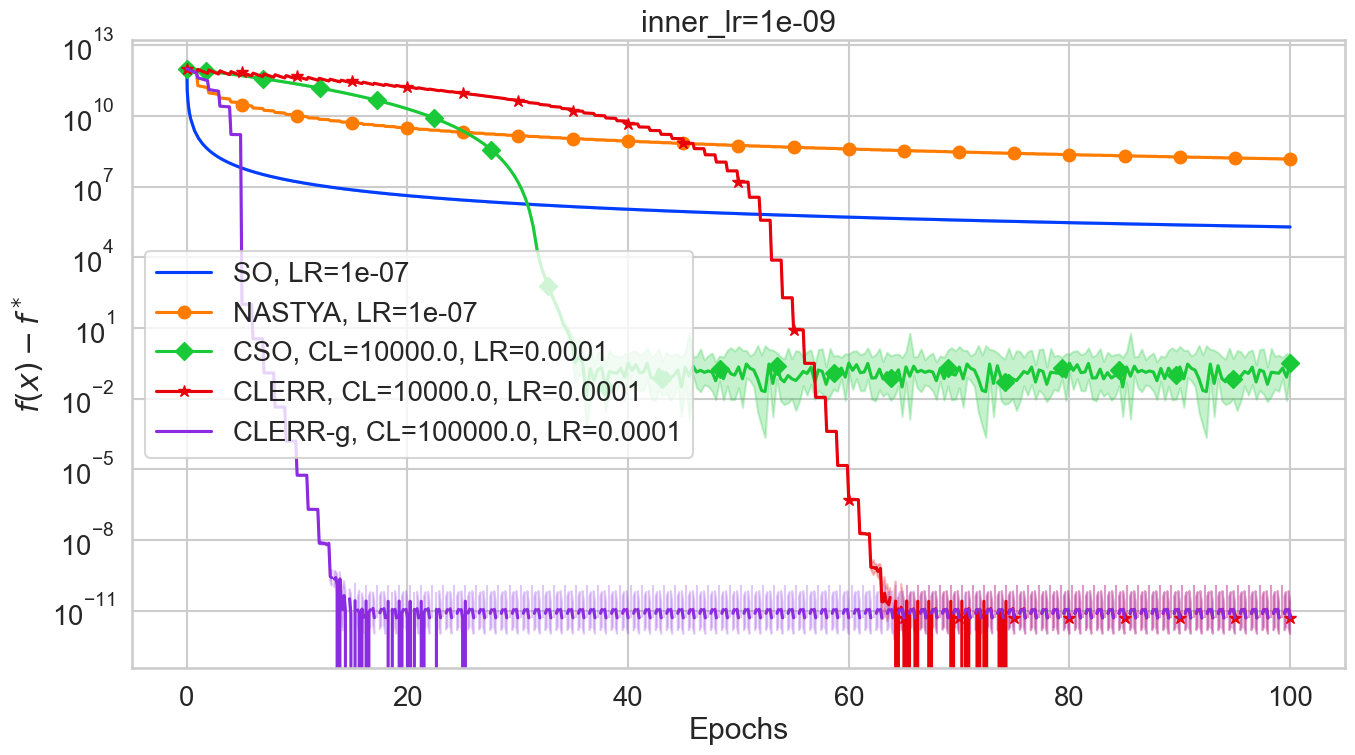

In [244]:
fig = plt.figure(figsize=(14, 8))
traces = [best_so_trace, best_nastya_trace, best_crr_trace, best_clerr_trace, best_clerr_g_trace]
labels = [
    f'SO, LR={best_so_trace.step_size}', 
    f'NASTYA, LR={best_nastya_trace.step_size}',
    f'CSO, CL={best_crr_trace.clip_level}, LR={best_crr_trace.step_size}', 
    f'CLERR, CL={best_clerr_trace.clip_level}, LR={best_crr_trace.step_size}', 
    f'CLERR-g, CL={best_clerr_g_trace.clip_level}, LR={best_crr_trace.step_size}'
]
markers = [',', 'o', 'D', '*', ',', ',']
for trace, label, marker in zip(traces, labels, markers):
    trace.plot_losses(f_opt=f_opt, label=label, marker=marker)
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title(f'inner_lr={in_step_size}')
fig.tight_layout()
plt.savefig(os.path.join(plot_path, f'{dataset}_func.png'))